# Kaggle Competition Info
In this competition, you’ll develop an NLP model driven by ML to accurately predict students’ potential math misconceptions based on student explanations in open-ended responses. This solution will suggest candidate misconceptions for these explanations, making it easier for teachers to identify and address students’ incorrect thinking, which is critical to improving student math learning.  
## Offical Link
https://www.kaggle.com/competitions/map-charting-student-math-misunderstandings 

## My LLM Model training Code for this Competition
<https://www.kaggle.com/code/johnsonhk88/student-math-misunderstand-by-llm-training>

# Recommand install package first at Add-ons --> Install Dependence

```python
!pip install -U bitsandbytes==0.47.0
!pip install -U peft==0.17.0
!pip install -U trl==0.21.0
!pip install -U accelerate==1.10.0
!pip install transformers==4.55.0
!pip install langchain==0.3.27
!pip install -U langchain-core==0.3.74
!pip install langchain-text-splitters==0.3.9
!pip install langchain-community==0.3.27
!pip install -U deepeval==3.3.9
```

In [1]:
import kagglehub

DEBUG = False#True

if DEBUG is True:
    !pip install git+https://github.com/huggingface/transformers.git  # install transformer from source
    # !pip install --upgrade torch datasets accelerate peft bitsandbytes trl
    # !pip install --upgrade accelerate peft bitsandbytes trl
    !pip install --upgrade datasets accelerate  # add datasets, accelerate , bitsndbytes
    # !pip install -U bitsandbytes==0.47.0
    # !pip install -U peft==0.17.0
    # !pip install -U trl==0.21.0
    !pip install --upgrade peft trl
    # !pip install -U accelerate==1.10.0
    # !pip install transformers==4.55.0
    !pip install langchain==0.3.27
    !pip install -U langchain-core==0.3.74
    !pip install langchain-text-splitters==0.3.9
    !pip install langchain-community==0.3.27
    !pip install -U deepeval==3.3.9
    !pip install protobuf==4.25.8 #4.49.0     # 6.30.2      #==3.20.3 #4.49.0
    !pip install triton==3.0.0   # avoid load LLM error
    !pip install --upgrade bitsandbytes

else:
    # package = kagglehub.package_import("/johnsonhk88/universal-llm-install-package2")
    # installDir = "/kaggle/input/universal-llm-install-package2/V7" #"/kaggle/input/universal-llm-install-package2/V7"
    installDir = "/kaggle/input/universal-llm-install-package2/V9"
    # installDir2 ="/kaggle/input/deepeval-open-source-llm-evaluation-framework"
    !pip install transformers --no-index --no-deps --find-links=file://{installDir}/transformers-4.45.2-py3-none-any.whl
    !pip install -U accelerate --no-index --no-deps --find-links=file://{installDir}/accelerate-1.0.1-py3-none-any.whl
    !pip install -U trl --no-index --no-deps --find-links=file://{installDir}/trl-0.11.4-py3-none-any.whl
    !pip install -U peft --no-index --no-deps --find-links=file://{installDir}/peft-0.14.0-py3-none-any.whl
    !pip install  bitsandbytes --no-index --no-deps --find-links=file://{installDir}/bitsandbytes-0.46.1-py3-none-manylinux_2_24_x86_64.whl
    
    !pip install -U langchain --no-index  --no-deps --find-links=file://{installDir}/langchain-0.3.3-py3-none-any.whl
    !pip install -U langchain_core --no-index  --no-deps --find-links=file://{installDir}/langchain_core-0.3.12-py3-none-any.whl
    !pip install -U langchain_text_splitters  --no-index  --no-deps  --find-links=file://{installDir}/langchain_text_splitters-0.3.0-py3-none-any.whl
    !pip install -U langchain_community  --no-index  --no-deps   --find-links=file://{installDir}/langchain_community-0.3.2-py3-none-any.whl
    # !pip install -U triton  --no-index --no-deps  --find-links=file://{installDir}/triton-3.4.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl
    # !pip install -U protobuf  --no-index  --no-deps  --find-links=file://{installDir}/protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl  
    
    # !pip install -U vllm   --no-index --find-links=file:///kaggle/input/vllm-inference/



Looking in links: file:///kaggle/input/universal-llm-install-package2/V9/transformers-4.45.2-py3-none-any.whl
Looking in links: file:///kaggle/input/universal-llm-install-package2/V9/accelerate-1.0.1-py3-none-any.whl
Looking in links: file:///kaggle/input/universal-llm-install-package2/V9/trl-0.11.4-py3-none-any.whl
Processing /kaggle/input/universal-llm-install-package2/V9/trl-0.11.4-py3-none-any.whl
Looking in links: file:///kaggle/input/universal-llm-install-package2/V9/peft-0.14.0-py3-none-any.whl
Looking in links: file:///kaggle/input/universal-llm-install-package2/V9/bitsandbytes-0.46.1-py3-none-manylinux_2_24_x86_64.whl
Processing /kaggle/input/universal-llm-install-package2/V9/bitsandbytes-0.46.1-py3-none-manylinux_2_24_x86_64.whl
Looking in links: file:///kaggle/input/universal-llm-install-package2/V9/langchain-0.3.3-py3-none-any.whl
Looking in links: file:///kaggle/input/universal-llm-install-package2/V9/langchain_core-0.3.12-py3-none-any.whl
Looking in links: file:///kaggle/

In [2]:
# !pip install triton==3.0.0
# !pip install triton==3.3.0

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import os, time , gc , json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import transformers




In [4]:
# !pip install trl==0.15.0


In [5]:
import trl
trl.__version__

'0.11.4'

In [6]:
import torch
from sklearn.model_selection import train_test_split

from transformers import (AutoTokenizer, 
                          BitsAndBytesConfig, 
                          AutoModelForCausalLM,
                          AutoModelForSequenceClassification,
                         TrainingArguments)

from datasets import Dataset, DatasetDict, load_dataset


# Fine tuning 
from trl import SFTTrainer, SFTConfig
from peft import (LoraConfig, 
                    PeftModel, 
                    get_peft_model)
                    # prepare_model_for_kbit_training)  #prepare_model_for_int8_training deprecated 

from sklearn.metrics import (classification_report, ConfusionMatrixDisplay, log_loss,
                             f1_score, accuracy_score, precision_score, recall_score)

2025-09-28 15:20:41.381212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759072841.583834      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759072841.640715      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/universal-llm-install-package2/V9/langchain_community-0.3.2-py3-none-any.whl
/kaggle/input/universal-llm-install-package2/V9/langsmith-0.1.136-py3-none-any.whl
/kaggle/input/universal-llm-install-package2/V9/langchain_core-0.3.12-py3-none-any.whl
/kaggle/input/universal-llm-install-package2/V9/accelerate-1.0.1-py3-none-any.whl
/kaggle/input/universal-llm-install-package2/V9/trl-0.11.4-py3-none-any.whl
/kaggle/input/universal-llm-install-package2/V9/langchain_text_splitters-0.3.0-py3-none-any.whl
/kaggle/input/universal-llm-install-package2/V9/bitsandbytes-0.46.1-py3-none-manylinux_2_24_x86_64.whl
/kaggle/input/universal-llm-install-package2/V9/huggingface_hub-0.26.0-py3-none-any.whl
/kaggle/input/universal-llm-install-package2/V9/protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl
/kaggle/input/universal-llm-install-package2/V9/triton-3.4.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl
/kaggle/input/universal-llm-install-package2/V9/langchain-0.3.3-py3-none-a

In [8]:
class CFG:
    DeepEval = False#True  # True must enable "Internet on" 
    SEED = 42

     # LLM Config 
    reportTo ="none"
    topK = 40
    topP = 1.0
    temperature = 0.1 #0.5
    repetition_penalty = 1.05 # 1.1
    maxOutToken = 300 #150#180 #100
    test_size = 0.001 #0.005 #0.005 #0.1 #0.01 #0.005 #0.01
    

    # Fine tuning Config
    maxLength = 384 #512 #256 #368 #512 #1024 
    reportTo = "none"
    maxEpoch = 0.01 #0.005 #0.01 #0.005 #0.5 #0.05 #0.02 #0.05  #0.1 #0.5 #1 #2
    evalSteps = 50 #20 #50 #30 #40 #20 
    learning_rate = 2e-5 #1e-5 #8e-5 #5e-5 #2e-5 #2e-4 #1e-4
    per_device_train_batch_size = 5 #4 #6 #8 #10#6#16 #6 #2 #8#6 #8
    per_device_eval_batch_size =  5 #4 #6 #8 #10 #6#16 #6 #2 #8#6 #8  
    # Lora config
    DROPOUT = 0.1 #0.05
    weight_decay = 0.01 

    warmup_steps= 10 #5# 10
    gradient_accumulation_steps = 4 #8 # 4 #2  #10
    maxTrainStep =  500 #120 #160 #100 #50#100 #250 #150 
    valDatasetSize = 50 #20 #10 #50 #500 # set validiation data size


    #model
    model1 = "/kaggle/input/qwen-3/transformers/8b/1"
    model2 = "/kaggle/input/qwen-3-reranker/transformers/4b/1"
    fineTunedmodel1 = "/kaggle/input/student-math-llm-fine-tune/transformers/default/10/student-math-llm-Fine-tune"
    
    #
    frac = 0.5 #0.3 #0.3 #0.3 #0.1 # Random resample data(reduce train data size )
    

    trainFile = "/kaggle/input/map-charting-student-math-misunderstandings/train.csv"
    testFile  = "/kaggle/input/map-charting-student-math-misunderstandings/test.csv"
    sampleFile = "/kaggle/input/map-charting-student-math-misunderstandings/sample_submission.csv"
    

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
torch.cuda.is_bf16_supported()

True

In [11]:
def clearMemory():
    for _ in range(5):
        torch.cuda.empty_cache()
        gc.collect()
        time.sleep(0.3)

In [12]:
clearMemory()

In [13]:
trainDF = pd.read_csv(CFG.trainFile)
trainDF.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NaN
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NaN
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NaN


In [14]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36696 entries, 0 to 36695
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              36696 non-null  int64 
 1   QuestionId          36696 non-null  int64 
 2   QuestionText        36696 non-null  object
 3   MC_Answer           36696 non-null  object
 4   StudentExplanation  36696 non-null  object
 5   Category            36696 non-null  object
 6   Misconception       9860 non-null   object
dtypes: int64(2), object(5)
memory usage: 2.0+ MB


In [15]:
trainDF.describe()

,row_id,QuestionId
count,36696.000000,36696.000000
mean,18347.500000,46356.825104
std,10593.367076,25617.723392
min,0.000000,31772.000000
25%,9173.750000,31777.000000
50%,18347.500000,32833.000000
75%,27521.250000,33474.000000
max,36695.000000,109465.000000


In [16]:
testDF = pd.read_csv(CFG.testFile)
testDF

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si..."
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.


In [17]:
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              3 non-null      int64 
 1   QuestionId          3 non-null      int64 
 2   QuestionText        3 non-null      object
 3   MC_Answer           3 non-null      object
 4   StudentExplanation  3 non-null      object
dtypes: int64(2), object(3)
memory usage: 252.0+ bytes


In [18]:
testDF.isnull().sum()

row_id                0
QuestionId            0
QuestionText          0
MC_Answer             0
StudentExplanation    0
dtype: int64

In [19]:
# Nan and Null check
trainDF.isnull().sum()


row_id                    0
QuestionId                0
QuestionText              0
MC_Answer                 0
StudentExplanation        0
Category                  0
Misconception         26836
dtype: int64

In [20]:
sample = pd.read_csv(CFG.sampleFile)
sample

,row_id,Category:Misconception
0,36696,True_Correct:NA False_Neither:NA False_Misconc...
1,36697,True_Correct:NA False_Neither:NA False_Misconc...
2,36698,True_Correct:NA False_Neither:NA False_Misconc...


In [21]:
sample.columns

Index(['row_id', 'Category:Misconception'], dtype='object')

## EDA
### Print Columns Values

In [22]:
def printAllcolumnsValue(df, showAll=True):
    """
    Print DataFrame columns values
    """
    # loop column
    for col in df.columns:
        if showAll is True:
            print(f"{col} : {df[col].unique()}") # print unique value
        else: # only print caterogy column
            if df[col].dtype == "object":
                print(f"{col} : {df[col].unique()}") # print unique value

def printSerieUnquieValue(df):
    """
    print data serie value
    """
    print(f" {df.unique()}")

In [23]:
printAllcolumnsValue(trainDF, showAll=True)

row_id : [    0     1     2 ... 36693 36694 36695]
QuestionId : [ 31772  31774  31777  31778  32829  32833  32835  33471  33472  33474
  76870  89443  91695 104665 109465]
QuestionText : ['What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]'
 'Calculate \\( \\frac{1}{2} \\div 6 \\)'
 'A box contains \\( 120 \\) counters. The counters are red or blue. \\( \\frac{3}{5} \\) of the counters are red.\nHow many red counters are there?'
 '\\( \\frac{A}{10}=\\frac{9}{15} \\) What is the value of \\( A \\) ?'
 '\\( 2 y=24 \\) What is the value of \\( y \\) ?'
 'Calculate \\( \\frac{2}{3} \\times 5 \\)'
 'Which number is the greatest?'
 'A bag contains \\( 24 \\) yellow and green balls. \\( \\frac{3}{8} \\) of the balls are yellow. How many of the balls are green?'
 '\\( \\frac{1}{3}+\\frac{2}{5}= \\)'
 'Sally has \\( \\frac{2}{3} \\) of a whole cake in the fridge. Robert eats \\( \\frac{

In [24]:
featureCols = trainDF.columns.tolist()
featureCols

['row_id',
 'QuestionId',
 'QuestionText',
 'MC_Answer',
 'StudentExplanation',
 'Category',
 'Misconception']

In [25]:
# clean data
trainDF["Misconception"]= trainDF["Misconception"].fillna("NA") # fill NaN to NA
trainDF["Misconception"].isnull().sum() # check Null 

0

#### combine into target columns

In [26]:

trainDF['target'] = trainDF["Category"]+":"+trainDF["Misconception"]
trainDF

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA
...,...,...,...,...,...,...,...,...
36691,36691,109465,The probability of an event occurring is \( 0....,Unlikely,very unlikely.,False_Neither,NA,False_Neither:NA
36692,36692,109465,The probability of an event occurring is \( 0....,Unlikely,yea pretty much unlikely from what it seems.,False_Neither,NA,False_Neither:NA
36693,36693,109465,The probability of an event occurring is \( 0....,Unlikely,yeah pretty unlikelyy from what it seems.,False_Neither,NA,False_Neither:NA
36694,36694,109465,The probability of an event occurring is \( 0....,Unlikely,you have 9 other numbers to get.,False_Neither,NA,False_Neither:NA


### Create Label

In [27]:
le = LabelEncoder()
trainDF["label"]= le.fit_transform(trainDF['target']) # encode caterogy into label

In [28]:
trainDF

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,37
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,37
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,64
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,64
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,37
...,...,...,...,...,...,...,...,...,...
36691,36691,109465,The probability of an event occurring is \( 0....,Unlikely,very unlikely.,False_Neither,NA,False_Neither:NA,36
36692,36692,109465,The probability of an event occurring is \( 0....,Unlikely,yea pretty much unlikely from what it seems.,False_Neither,NA,False_Neither:NA,36
36693,36693,109465,The probability of an event occurring is \( 0....,Unlikely,yeah pretty unlikelyy from what it seems.,False_Neither,NA,False_Neither:NA,36
36694,36694,109465,The probability of an event occurring is \( 0....,Unlikely,you have 9 other numbers to get.,False_Neither,NA,False_Neither:NA,36


In [29]:
# print all unique t
printAllcolumnsValue(trainDF, showAll=True)

row_id : [    0     1     2 ... 36693 36694 36695]
QuestionId : [ 31772  31774  31777  31778  32829  32833  32835  33471  33472  33474
  76870  89443  91695 104665 109465]
QuestionText : ['What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]'
 'Calculate \\( \\frac{1}{2} \\div 6 \\)'
 'A box contains \\( 120 \\) counters. The counters are red or blue. \\( \\frac{3}{5} \\) of the counters are red.\nHow many red counters are there?'
 '\\( \\frac{A}{10}=\\frac{9}{15} \\) What is the value of \\( A \\) ?'
 '\\( 2 y=24 \\) What is the value of \\( y \\) ?'
 'Calculate \\( \\frac{2}{3} \\times 5 \\)'
 'Which number is the greatest?'
 'A bag contains \\( 24 \\) yellow and green balls. \\( \\frac{3}{8} \\) of the balls are yellow. How many of the balls are green?'
 '\\( \\frac{1}{3}+\\frac{2}{5}= \\)'
 'Sally has \\( \\frac{2}{3} \\) of a whole cake in the fridge. Robert eats \\( \\frac{

### Get Label Catergory class name

In [30]:

targetClasses = le.classes_   
targetClasses

array(['False_Correct:NA', 'False_Misconception:Adding_across',
       'False_Misconception:Adding_terms', 'False_Misconception:Additive',
       'False_Misconception:Base_rate', 'False_Misconception:Certainty',
       'False_Misconception:Definition',
       'False_Misconception:Denominator-only_change',
       'False_Misconception:Division', 'False_Misconception:Duplication',
       'False_Misconception:Firstterm', 'False_Misconception:FlipChange',
       'False_Misconception:Ignores_zeroes',
       'False_Misconception:Incomplete',
       'False_Misconception:Incorrect_equivalent_fraction_addition',
       'False_Misconception:Interior',
       'False_Misconception:Inverse_operation',
       'False_Misconception:Inversion', 'False_Misconception:Irrelevant',
       'False_Misconception:Longer_is_bigger', 'False_Misconception:Mult',
       'False_Misconception:Multiplying_by_4',
       'False_Misconception:Not_variable', 'False_Misconception:Positive',
       'False_Misconception:Scal

In [31]:
nClasses = len(targetClasses)
nClasses

65

In [32]:
print(f"Train shape: {trainDF.shape} with {nClasses} target classes")
trainDF.head()

Train shape: (36696, 9) with 65 target classes


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,37
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,37
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,64
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,64
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,37


# Feature Engineering

### Add correct answer flag

In [33]:
idx = trainDF.apply(lambda row: row["Category"].split("_")[0] , axis=1) == "True" # get Category with True 
idx

0         True
1         True
2         True
3         True
4         True
         ...  
36691    False
36692    False
36693    False
36694    False
36695    False
Length: 36696, dtype: bool

In [34]:
correct = trainDF.loc[idx].copy()
correct

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,37
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,37
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,64
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,64
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,37
...,...,...,...,...,...,...,...,...,...
36275,36275,109465,The probability of an event occurring is \( 0....,Likely,very close to one but not one so it cant be ce...,True_Correct,NA,True_Correct:NA,37
36276,36276,109465,The probability of an event occurring is \( 0....,Likely,very high probability however it's not certain,True_Neither,NA,True_Neither:NA,64
36277,36277,109465,The probability of an event occurring is \( 0....,Likely,we should use likely because we dont know for ...,True_Neither,NA,True_Neither:NA,64
36278,36278,109465,The probability of an event occurring is \( 0....,Likely,well 0.9 = 90% and the only way something can ...,True_Correct,NA,True_Correct:NA,37


In [35]:
# group MC anwser with count 
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False) # sort value 
correct

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label,c
61,61,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),3 goes into 9 three times which makes it one t...,True_Correct,NA,True_Correct:NA,37,2348
7,7,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1/3 because 3/9 simplified divided by 3 would ...,True_Correct,NA,True_Correct:NA,37,2348
6,6,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1/3 and 3/9 are not shaded but they are equal ...,True_Correct,NA,True_Correct:NA,37,2348
5,5,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 third because 6 over 9 is 2 thirds and 1 thi...,True_Correct,NA,True_Correct:NA,37,2348
60,60,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),3 from the 9 triangles are not shaded and 3/9 ...,True_Correct,NA,True_Correct:NA,37,2348
...,...,...,...,...,...,...,...,...,...,...
14338,14338,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),It is six because they are both equal to 3over5.,True_Correct,NA,True_Correct:NA,37,12
14335,14335,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),Il believe that is the ansewer because I calcu...,True_Neither,NA,True_Neither:NA,64,12
14321,14321,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),I think it's C because 6/10 is the same as 9/15.,True_Correct,NA,True_Correct:NA,37,12
14280,14280,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),"Because 10 is 2 / 3 of 15, and 2 is 6.",True_Neither,NA,True_Neither:NA,64,12


In [36]:
# Drop duplicateds ID
correct = correct.drop_duplicates(['QuestionId']) #drop dprlicate id
correct = correct[['QuestionId','MC_Answer']]
correct

,QuestionId,MC_Answer
61,31772,\( \frac{1}{3} \)
7430,31774,\( \frac{1}{12} \)
10770,31777,\( 72 \)
14266,31778,\( 6 \)
14440,32829,\( 12 \)
22004,32835,\( 6.2 \)
24278,33472,\( \frac{11}{15} \)
18135,32833,\( 3 \frac{1}{3} \)
33183,91695,\( 26 \)
30937,89443,\( -3 \)


In [37]:
# set correct flag = 1
correct["is_correct"] = 1
correct

,QuestionId,MC_Answer,is_correct
61,31772,\( \frac{1}{3} \),1
7430,31774,\( \frac{1}{12} \),1
10770,31777,\( 72 \),1
14266,31778,\( 6 \),1
14440,32829,\( 12 \),1
22004,32835,\( 6.2 \),1
24278,33472,\( \frac{11}{15} \),1
18135,32833,\( 3 \frac{1}{3} \),1
33183,91695,\( 26 \),1
30937,89443,\( -3 \),1


### Merge training data

In [38]:

trainDF = trainDF.merge(correct, on=['QuestionId','MC_Answer'], how='left')
trainDF["is_correct"] = trainDF["is_correct"].fillna(0) # fill miss data to 0

In [39]:
trainDF["is_correct"] = trainDF["is_correct"].astype(int) # change is_correct data type to int

In [40]:
trainDF

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label,is_correct
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,37,1
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,37,1
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,64,1
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,64,1
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,37,1
...,...,...,...,...,...,...,...,...,...,...
36691,36691,109465,The probability of an event occurring is \( 0....,Unlikely,very unlikely.,False_Neither,NA,False_Neither:NA,36,0
36692,36692,109465,The probability of an event occurring is \( 0....,Unlikely,yea pretty much unlikely from what it seems.,False_Neither,NA,False_Neither:NA,36,0
36693,36693,109465,The probability of an event occurring is \( 0....,Unlikely,yeah pretty unlikelyy from what it seems.,False_Neither,NA,False_Neither:NA,36,0
36694,36694,109465,The probability of an event occurring is \( 0....,Unlikely,you have 9 other numbers to get.,False_Neither,NA,False_Neither:NA,36,0


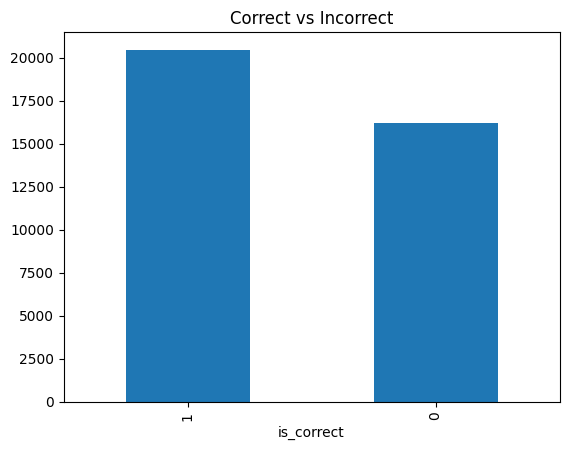

In [41]:
trainDF["is_correct"].value_counts().plot(kind="bar", title="Correct vs Incorrect");

## Seem the training Data extremely imbalance

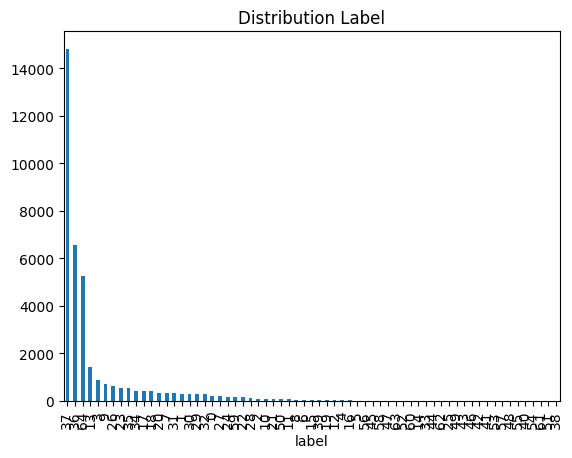

In [42]:
trainDF["label"].value_counts().plot(kind="bar", title="Distribution Label");

In [43]:
trainDF["label"].value_counts().describe()

count       65.000000
mean       564.553846
std       2071.725263
min          1.000000
25%          6.000000
50%         50.000000
75%        291.000000
max      14802.000000
Name: count, dtype: float64

In [44]:
trainDF["label"].value_counts()[:50]  # top 50

label
37    14802
36     6542
64     5265
13     1446
3       891
9       698
26      618
23      564
35      550
34      412
17      409
18      409
20      345
7       332
31      328
1       306
30      291
29      282
32      273
0       227
27      198
24      179
59      162
22      153
28      128
2        97
10       96
21       93
50       88
11       74
8        58
6        51
15       50
39       38
19       23
12       23
4        22
16       21
5        18
56       17
45       11
58        8
47        8
63        8
52        8
60        8
14        7
33        6
44        6
62        6
Name: count, dtype: int64

## Merge into Test /Submit Data

In [45]:
testDF = testDF.merge(correct, on=['QuestionId','MC_Answer'], how='left')
testDF["is_correct"] = testDF["is_correct"].fillna(0)  # fill Na to 0


In [46]:
testDF["is_correct"] = testDF["is_correct"].astype(int)
testDF

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_correct
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",1
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,0
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,1


## Get Answer choices 

In [47]:
from IPython.display import display, Math, Latex

In [48]:
temp = trainDF.groupby(["QuestionId", "MC_Answer"]).size().reset_index(name="count")
temp

,QuestionId,MC_Answer,count
0,31772,\( \frac{1}{3} \),2348
1,31772,\( \frac{3}{6} \),412
2,31772,\( \frac{3}{8} \),118
3,31772,\( \frac{3}{9} \),1979
4,31774,\( 3 \),659
5,31774,\( \frac{1}{12} \),1918
6,31774,\( \frac{1}{3} \),251
7,31774,\( \frac{6}{2} \),287
8,31777,\( 24 \),255
9,31777,\( 48 \),406


In [49]:
# add Ranking
temp["rank"] = temp.groupby("QuestionId")['count'].rank(method='dense', ascending=False).astype(int) - 1
temp

,QuestionId,MC_Answer,count,rank
0,31772,\( \frac{1}{3} \),2348,0
1,31772,\( \frac{3}{6} \),412,2
2,31772,\( \frac{3}{8} \),118,3
3,31772,\( \frac{3}{9} \),1979,1
4,31774,\( 3 \),659,1
5,31774,\( \frac{1}{12} \),1918,0
6,31774,\( \frac{1}{3} \),251,3
7,31774,\( \frac{6}{2} \),287,2
8,31777,\( 24 \),255,3
9,31777,\( 48 \),406,1


In [50]:
temp = temp.drop('count',axis=1)
temp = temp.sort_values(['QuestionId','rank'])
temp

,QuestionId,MC_Answer,rank
0,31772,\( \frac{1}{3} \),0
3,31772,\( \frac{3}{9} \),1
1,31772,\( \frac{3}{6} \),2
2,31772,\( \frac{3}{8} \),3
5,31774,\( \frac{1}{12} \),0
4,31774,\( 3 \),1
7,31774,\( \frac{6}{2} \),2
6,31774,\( \frac{1}{3} \),3
11,31777,\( 72 \),0
9,31777,\( 48 \),1


In [51]:
Qid = temp["QuestionId"].unique() # get unique questionid
for q in Qid:
    question = trainDF.loc[trainDF.QuestionId==q].iloc[0]["QuestionText"] # get Question Text for specific QuestionId
    choices = temp.loc[temp["QuestionId"] ==q]["MC_Answer"].values #
    labels="ABCD" # define labels name
    choiceStr = " ".join([f"({labels[i]}) {choice}" for  i, choice in enumerate(choices)])
    print()
    display(Latex(f"Question Id: {q}: {question}"))
    display(Latex(f"MC Answer: {choiceStr}\n\r"))
    
    # print(f"question: {question}, choices: {choices}  \n\r")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [52]:
len(Qid)

15

In [53]:
clearMemory()

<!-- ### Undersampling is simple way to reduce impact for training imbalance class -->
# Imbalance Class Handling
To address the extreme class imbalance in your training dataset, you can apply sampling techniques to create a more balanced dataset for fine-tuning. Here are common and effective approaches:

### Undersampling the Majority Classes
Randomly remove samples from highly frequent classes (e.g., label 37 with 14,802 samples) to reduce their dominance.

Techniques like Near Miss or Tomek Links select majority samples close to minority samples to keep important points and remove redundant ones.

Downsampling ensures batches contain more representative samples of minority classes, helping the model learn minority patterns better.

### Oversampling the Minority Classes
Increase the number of samples in minority classes by replicating existing samples or synthetically generating new ones (e.g., SMOTE or Perceptual Borderline SMOTE).

Synthetic oversampling creates new minority samples by interpolating between nearest neighbors, improving representation without losing information.

### Hybrid Sampling
Combine undersampling and oversampling to balance the dataset effectively without losing valuable majority class information.

For example, reduce majority class samples moderately and apply synthetic oversampling to minority classes.

Hybrid methods have been shown to perform well in highly imbalanced multi-class settings.

## Additional Suggestions
- Class Weights: Alternatively or additionally, assign higher loss weights to minority classes during training to force the model to pay more attention to them without changing the dataset distribution.

- Experiment: It’s important to experiment with the degree of under- and oversampling as well as weighting to optimize balanced learning.


By applying these resampling strategies, the data balance improves, which can help stabilize metrics like mAP during fine-tuning and improve overall model robustness across all classes.To address the extreme class imbalance in your training dataset, a common solution is to use sampling techniques to balance the dataset:

- Undersampling: Reduce samples from majority classes by randomly removing some instances or using informed methods like Near Miss or Tomek Links, which selectively remove samples from majority classes near minority class boundaries. This prevents the model from overwhelming bias towards large classes.

- Oversampling: Increase samples from minority classes by duplicating instances or generating synthetic samples using methods like SMOTE or Perceptual Borderline SMOTE, which interpolate between minority samples to create new, plausible instances.

- Hybrid methods: Combine undersampling of large classes with oversampling of small classes to maintain data diversity and balance effectively.

- Class weighting: Alternatively, or in addition, use class-weighted loss functions to penalize misclassification of minority classes more heavily without changing data distribution.

It's recommended to experiment with these approaches and their parameters, aiming for a balanced representation that helps the model learn all classes well and stabilizes performance metrics like mAP during fine-tuning.


### how to apply class weight in transformers
To apply class weights in fine-tuning transformers with PyTorch, you typically define a weighted loss function that penalizes misclassification of underrepresented classes more heavily. Here's how you can do it:

### How to Apply Class Weights in Transformers (PyTorch)
Calculate class weights: Create a tensor of class weights inversely proportional to class frequencies.

- Use weighted loss function: Pass the class weights to PyTorch's nn.CrossEntropyLoss(weight=class_weights). This makes the loss sensitive to class imbalance.

Integrate with Hugging Face Trainer:

Subclass the Trainer class.

Override the compute_loss method to apply the weighted loss function instead of the default one.

Example Code
python
import torch
from torch import nn
from transformers import Trainer

# Define class weights as a torch tensor, for example:
class_weights = torch.tensor([0.1, 0.3, 0.6], device='cuda')  # Replace with actual weights

# Custom Trainer to use weighted loss
```
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
```

This approach lets the transformer model focus more on minority classes by increasing their contribution to the loss during training. The class weights tensor should be calculated based on class frequencies from your dataset.

This method is the standard way to apply class weights during transformer fine-tuning in PyTorch and Hugging Face Trainer.



In [54]:
sampleValue =  14802 //5
sampleValue

2960

In [55]:
 # median value = 50   
(trainDF["label"].value_counts() > sampleValue).sum() # number of class > sample value counts

3

## Use Mix Undersample and Oversample Improve performance

In [56]:
# Assume df is your DataFrame and 'label' is your class column
desired_count = sampleValue #50
def resample_group_mix(group):
    '''
    Resample with hybird undersample and Oversample
    '''
    n = len(group)
    if n > desired_count:
        # Undersample if more than desired_count
        return group.sample(n=desired_count, random_state=42)
    elif n < desired_count:
        # Oversample with replacement if less than desired_count
        return group.sample(n=desired_count, replace=True, random_state=42)
    else:
        # Keep as is if exactly desired_count
        return group

In [57]:
# conditional oversample 
oversample_count = 1000
def resample_group_oversample(group):
    '''
    Resample with condition Oversample , keep major
    '''
    n = len(group)
    if n < oversample_count:
        # Oversample with replacement if less than desired_count
        return group.sample(n=oversample_count, replace=True, random_state=42)
    else:
        # Keep as is if exactly desired_count
        return group
    

In [58]:
#

# Group by class and sample min(desired_count, current_count) from each class
# trainDF_balanced = trainDF.groupby('label', group_keys=False).apply(lambda x: x.sample(n=min(len(x), desired_count), random_state=42))
trainDF_balanced = trainDF.groupby('label', group_keys=False).apply(resample_group_oversample)

print(trainDF_balanced['label'].value_counts())

label
37    14802
36     6542
64     5265
13     1446
47     1000
      ...  
28     1000
29     1000
30     1000
31     1000
16     1000
Name: count, Length: 65, dtype: int64


/tmp/ipykernel_36/4246594355.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trainDF_balanced = trainDF.groupby('label', group_keys=False).apply(resample_group_oversample)


In [59]:
trainDF_balanced['label'].value_counts()[:55]

label
37    14802
36     6542
64     5265
13     1446
47     1000
46     1000
45     1000
44     1000
43     1000
42     1000
40     1000
39     1000
38     1000
35     1000
34     1000
33     1000
41     1000
49     1000
50     1000
51     1000
52     1000
53     1000
54     1000
55     1000
56     1000
57     1000
58     1000
59     1000
60     1000
61     1000
62     1000
63     1000
48     1000
0      1000
1      1000
2      1000
3      1000
4      1000
5      1000
6      1000
7      1000
8      1000
9      1000
10     1000
11     1000
12     1000
14     1000
15     1000
32     1000
17     1000
18     1000
19     1000
20     1000
21     1000
22     1000
Name: count, dtype: int64

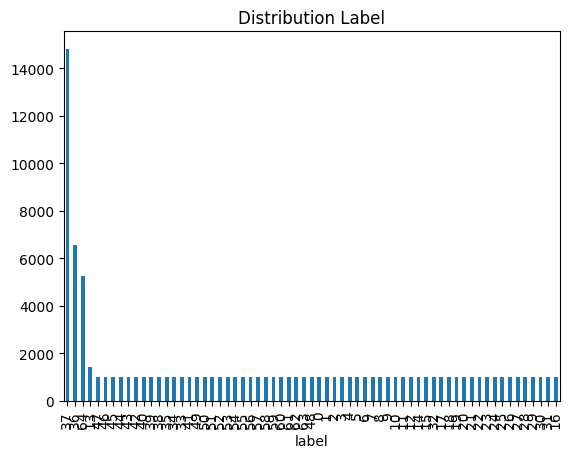

In [60]:
trainDF_balanced['label'].value_counts().plot(kind="bar", title="Distribution Label");

In [61]:
trainDF_balanced = trainDF_balanced.reset_index(drop=True)

In [62]:
trainDF_balanced

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label,is_correct
0,14350,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),This is because youu can time both 10 and 15 t...,False_Correct,NA,False_Correct:NA,0,0
1,25280,33472,\( \frac{1}{3}+\frac{2}{5}= \),\( \frac{11}{30} \),i know this because a common denominator is 15...,False_Correct,NA,False_Correct:NA,0,0
2,11228,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 3 \),i divided by 3 and timesed by 2,False_Correct,NA,False_Correct:NA,0,0
3,2945,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{9} \),3 outt of 9 are not-shaded. also 1/3,False_Correct,NA,False_Correct:NA,0,0
4,16143,32829,\( 2 y=24 \) What is the value of \( y \) ?,\( 22 \),24%2=12\n12 so the answer is 12 because the 2...,False_Correct,NA,False_Correct:NA,0,0
...,...,...,...,...,...,...,...,...,...,...
89050,36262,109465,The probability of an event occurring is \( 0....,Likely,this is because a 9 out of 10 chance means tha...,True_Neither,NA,True_Neither:NA,64,1
89051,36271,109465,The probability of an event occurring is \( 0....,Likely,this is your answer because 1 would be certain...,True_Neither,NA,True_Neither:NA,64,1
89052,36274,109465,The probability of an event occurring is \( 0....,Likely,u can use the process of elimination because c...,True_Neither,NA,True_Neither:NA,64,1
89053,36276,109465,The probability of an event occurring is \( 0....,Likely,very high probability however it's not certain,True_Neither,NA,True_Neither:NA,64,1


In [63]:
trainDF_balanced.isnull().sum() # null checking

row_id                0
QuestionId            0
QuestionText          0
MC_Answer             0
StudentExplanation    0
Category              0
Misconception         0
target                0
label                 0
is_correct            0
dtype: int64

In [64]:
# !pip uninstall protobuf
# !pip install protobuf==3.20.3

## LLM inital

In [65]:
bnbConfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=True ) # Activate netsed quantization for 4bit base 

In [66]:
# !pip install triton==3.4.0
# !pip install triton==3.0.0
# !pip install protobuf==6.30.2

### Load LLM Model and Tokenizer

In [67]:
clearMemory()

In [68]:
import trl
trl.__version__

'0.11.4'

In [69]:


import triton

triton.__version__

'3.2.0'

In [70]:
# !pip install bitsandbytes==0.46.1

In [71]:
import bitsandbytes
# bitsandbytes.__version__

In [72]:
# Mapping from label to ID (label2id)
label2id = {label: i for i, label in enumerate(le.classes_)}
print(f"Label to ID mapping: {label2id}")

Label to ID mapping: {'False_Correct:NA': 0, 'False_Misconception:Adding_across': 1, 'False_Misconception:Adding_terms': 2, 'False_Misconception:Additive': 3, 'False_Misconception:Base_rate': 4, 'False_Misconception:Certainty': 5, 'False_Misconception:Definition': 6, 'False_Misconception:Denominator-only_change': 7, 'False_Misconception:Division': 8, 'False_Misconception:Duplication': 9, 'False_Misconception:Firstterm': 10, 'False_Misconception:FlipChange': 11, 'False_Misconception:Ignores_zeroes': 12, 'False_Misconception:Incomplete': 13, 'False_Misconception:Incorrect_equivalent_fraction_addition': 14, 'False_Misconception:Interior': 15, 'False_Misconception:Inverse_operation': 16, 'False_Misconception:Inversion': 17, 'False_Misconception:Irrelevant': 18, 'False_Misconception:Longer_is_bigger': 19, 'False_Misconception:Mult': 20, 'False_Misconception:Multiplying_by_4': 21, 'False_Misconception:Not_variable': 22, 'False_Misconception:Positive': 23, 'False_Misconception:Scale': 24, 'Fa

In [73]:
# Mapping from ID to label (id2label)
id2label = {i: label for i, label in enumerate(le.classes_)}
print(f"ID to label mapping: {id2label}")

ID to label mapping: {0: 'False_Correct:NA', 1: 'False_Misconception:Adding_across', 2: 'False_Misconception:Adding_terms', 3: 'False_Misconception:Additive', 4: 'False_Misconception:Base_rate', 5: 'False_Misconception:Certainty', 6: 'False_Misconception:Definition', 7: 'False_Misconception:Denominator-only_change', 8: 'False_Misconception:Division', 9: 'False_Misconception:Duplication', 10: 'False_Misconception:Firstterm', 11: 'False_Misconception:FlipChange', 12: 'False_Misconception:Ignores_zeroes', 13: 'False_Misconception:Incomplete', 14: 'False_Misconception:Incorrect_equivalent_fraction_addition', 15: 'False_Misconception:Interior', 16: 'False_Misconception:Inverse_operation', 17: 'False_Misconception:Inversion', 18: 'False_Misconception:Irrelevant', 19: 'False_Misconception:Longer_is_bigger', 20: 'False_Misconception:Mult', 21: 'False_Misconception:Multiplying_by_4', 22: 'False_Misconception:Not_variable', 23: 'False_Misconception:Positive', 24: 'False_Misconception:Scale', 25:

In [74]:
if device.type == "cuda":
    model = AutoModelForSequenceClassification.from_pretrained(
        #CFG.model2,  #CFG.model1, #CFG.model3,
        CFG.fineTunedmodel1,
        num_labels= nClasses,
        id2label =id2label,
        label2id = label2id,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        quantization_config= bnbConfig,
        trust_remote_code=False,
        problem_type="single_label_classification", 
    )

else: 
     model = AutoModelForSequenceClassification.from_pretrained(
        # CFG.model2,  #CFG.model1 #CFG.model3,
        CFG.fineTunedmodel1,
        num_labels= nClasses,
        id2label =id2label,
        label2id = label2id,
        device_map="auto",
        trust_remote_code=False,
        problem_type="single_label_classification", 
    )

tokenizer = AutoTokenizer.from_pretrained(CFG.model2)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Qwen3ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/qwen-3-reranker/transformers/4b/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
model

Qwen3ForSequenceClassification(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151669, 2560)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=2560, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=2560, out_features=1024, bias=False)
            (lora_dropout): Modul

In [76]:
if CFG.DeepEval:
    from deepeval.models.base_model import DeepEvalBaseLLM
    from deepeval.test_case import LLMTestCase, LLMTestCaseParams
    from deepeval.metrics import GEval
    # from deepeval import evaluate
    from deepeval.metrics import AnswerRelevancyMetric
    # from deepeval.benchmarks import MMLU, HellaSwag, HumanEval,TruthfulQA
    # from deepeval.benchmarks.tasks import HumanEvalTask, HellaSwagTask, MMLUTask, TruthfulQATask
    # from deepeval.benchmarks.modes import TruthfulQAMode 

## Prepare Training Dataset

In [77]:
# Random Resample Dataset
# trainDF = trainDF.sample(frac=1.0, replace=True)
# trainDF = trainDF.reset_index(drop=True)
# trainDF

trainDF_balanced= trainDF_balanced.sample(frac=1.0, replace=True)
trainDF_balanced = trainDF_balanced.reset_index(drop=True)
trainDF_balanced

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label,is_correct
0,22356,33471,A bag contains \( 24 \) yellow and green balls...,\( 15 \),because i found ot what is 3/8 not as a fraction,True_Misconception,Wrong_fraction,True_Misconception:Wrong_fraction,62,1
1,8895,31777,A box contains \( 120 \) counters. The counter...,\( 60 \),devide by five and timeas by 3.,False_Correct,NA,False_Correct:NA,0,0
2,20210,32835,Which number is the greatest?,\( 6.0001 \),i think this because it has the most place hol...,False_Misconception,Longer_is_bigger,False_Misconception:Longer_is_bigger,19,0
3,12320,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 4 \),i think this because you have to find out what...,False_Neither,NA,False_Neither:NA,36,0
4,31032,89443,What number belongs in the box?\n\(\n(-8)-(-5)...,\( -3 \),i worked out what 8-5 was and just put the '-'...,True_Misconception,Tacking,True_Misconception:Tacking,59,1
...,...,...,...,...,...,...,...,...,...,...
89050,29288,76870,This is part of a regular polygon. How many si...,\( 6 \),it would only fit 3 times.,False_Neither,NA,False_Neither:NA,36,0
89051,30648,89443,What number belongs in the box?\n\(\n(-8)-(-5)...,\( -3 \),because to - becomes an + so the equation is a...,True_Correct,NA,True_Correct:NA,37,1
89052,20203,32835,Which number is the greatest?,\( 6.0001 \),i think d because it has more decimal places.,False_Misconception,Longer_is_bigger,False_Misconception:Longer_is_bigger,19,0
89053,21212,32835,Which number is the greatest?,\( 6.2 \),d because it has a 6 the same as a but it also...,True_Misconception,Longer_is_bigger,True_Misconception:Longer_is_bigger,51,1


In [78]:
PROMPT_FORMAT1 = """\
You are an expert in identifying math misconceptions from student explanations.

Question: {QuestionText}
Answer: {MC_Answer}
Correct: {Correct}
Student Explanation: {StudentExplanation}

Identify the specific type of math misconception in the student's explanation.
Give a short, clear label for the misconception.
"""

PROMPT_FORMAT2 = """\
You are an expert educational diagnostician specializing in identifying students' math misconceptions from their written explanations.
Your task is to analyze the student's explanation and classify the specific type of misconception they demonstrate.

Question: {QuestionText}
Answer: {MC_Answer}
Correct: {Correct}
Student Explanation: {StudentExplanation}

Based on the information above, identify and label the underlying math misconception in the student's explanation.
Provide a clear and concise classification of the misconception type.
"""

PROMPT_FORMAT3 = """\
You are an expert in analyzing students' answers to math problems and identifying specific types of misunderstandings.
Given the following information, classify the student's misunderstanding.

Question: {QuestionText}
Answer: {MC_Answer}
Correct: {Correct}
Student Explanation: {StudentExplanation}

Please provide the type of misunderstanding the student has.
"""

PROMPT_FORMAT4 = """\
You are a specialist in identifying the types of misunderstandings that arise from students’ answers to math problems.
Based on the information provided below, please determine what kind of misunderstanding the student has.

Question: {QuestionText}
Answer: {MC_Answer}
Correct: {Correct}
Student Explanation: {StudentExplanation}
"""


In [79]:
def generateTrainContent(row):
    x= "True"
    if not row["is_correct"]:
        x= "False"
    return PROMPT_FORMAT3.format(
        QuestionText=row['QuestionText'],
        MC_Answer=row['MC_Answer'],
        Correct=x,
        StudentExplanation=row['StudentExplanation']
        
    )

In [80]:
# trainDF["LLM_Content"]= trainDF.apply(generateTrainContent, axis=1)
trainDF_balanced["LLM_Content"] = trainDF_balanced.apply(generateTrainContent, axis=1)

In [81]:
testDF["LLM_Content"]= testDF.apply(generateTrainContent, axis=1)

In [82]:
# print one of example
print(trainDF_balanced["LLM_Content"].values[0])

You are an expert in analyzing students' answers to math problems and identifying specific types of misunderstandings.
Given the following information, classify the student's misunderstanding.

Question: A bag contains \( 24 \) yellow and green balls. \( \frac{3}{8} \) of the balls are yellow. How many of the balls are green?
Answer: \( 15 \)
Correct: True
Student Explanation: because i found ot what is 3/8 not as a fraction

Please provide the type of misunderstanding the student has.



In [83]:
print(testDF["LLM_Content"].values[0])

You are an expert in analyzing students' answers to math problems and identifying specific types of misunderstandings.
Given the following information, classify the student's misunderstanding.

Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Answer: \( \frac{1}{3} \)
Correct: True
Student Explanation: I think that 1/3 is the answer, as it's the simplest form of 3/9.

Please provide the type of misunderstanding the student has.



## lenght of the LLM conntent

In [84]:
# trainDF["Length"] = trainDF["LLM_Content"].str.len()
trainDF_balanced["Length"] = [len(tokenizer.encode(t, truncation=False)) for t in trainDF_balanced["LLM_Content"]]


trainDF_balanced["Length"].describe()

count    89055.000000
mean       110.878087
std         21.057916
min         69.000000
25%         96.000000
50%        108.000000
75%        123.000000
max        268.000000
Name: Length, dtype: float64

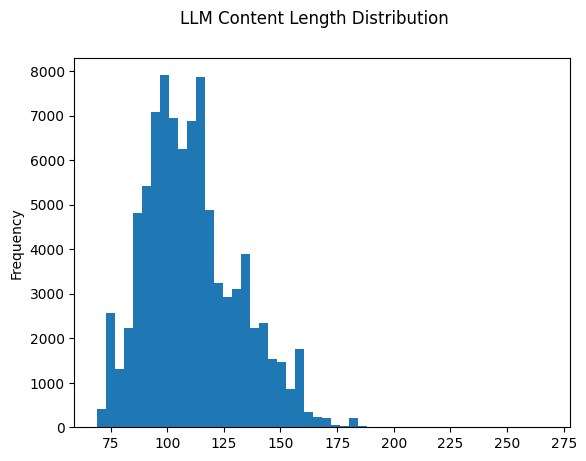

In [85]:
trainDF_balanced["Length"].plot(kind='hist', bins=50, subplots=True,sharex=True,sharey=True, title='LLM Content Length Distribution');

In [86]:
MAX_LEN = 384 #256 #512
L = (np.array(trainDF_balanced["Length"])>MAX_LEN).sum()
print(f"There are {L} train sample(s) with more than {MAX_LEN} tokens")

There are 0 train sample(s) with more than 384 tokens


### MAX window size 256 is suitable for training 

## Create Dataset

In [87]:
len(trainDF_balanced) , round(len(trainDF_balanced) * 0.85) # check train data size

(89055, 75697)

In [88]:
totalTrainSize= len(trainDF_balanced)
totalTrainSize

89055

In [89]:
setMaxTrainData = totalTrainSize - CFG.valDatasetSize
setMaxTrainData

89005

### Create Dataset for Train/Validation

In [90]:


# tempTrainDF , tempValDF = train_test_split(trainDF , stratify= trainDF["is_correct"], test_size=test_size, random_state=42)
tempTrainDF , tempValDF = train_test_split(trainDF_balanced ,  test_size=CFG.test_size, random_state=42)

In [91]:
tempTrainDF

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label,is_correct,LLM_Content,Length
38252,2635,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),because there is 6 shaded and 3 not shaded,False_Misconception,WNB,False_Misconception:WNB,30,0,You are an expert in analyzing students' answe...,112
2997,18420,32833,Calculate \( \frac{2}{3} \times 5 \),\( \frac{10}{15} \),I think it's because when times a fraction by ...,False_Neither,NA,False_Neither:NA,36,0,You are an expert in analyzing students' answe...,116
66308,21212,32835,Which number is the greatest?,\( 6.2 \),d because it has a 6 the same as a but it also...,True_Misconception,Longer_is_bigger,True_Misconception:Longer_is_bigger,51,1,You are an expert in analyzing students' answe...,88
65630,25284,33472,\( \frac{1}{3}+\frac{2}{5}= \),\( \frac{11}{30} \),i think it is 11/30 because if youu convert it...,False_Misconception,Incorrect_equivalent_fraction_addition,False_Misconception:Incorrect_equivalent_fract...,14,0,You are an expert in analyzing students' answe...,116
47822,17961,32833,Calculate \( \frac{2}{3} \times 5 \),\( 3 \frac{1}{3} \),its 2x5=10 and 3x5=15 and its ten fifteenths\n...,True_Misconception,Duplication,True_Misconception:Duplication,44,1,You are an expert in analyzing students' answe...,106
...,...,...,...,...,...,...,...,...,...,...,...,...
6265,13199,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 6 \),I think it's C because 15-6=9,True_Misconception,Additive,True_Misconception:Additive,39,1,You are an expert in analyzing students' answe...,100
54886,15189,32829,\( 2 y=24 \) What is the value of \( y \) ?,\( 12 \),i think because 2*12is 24 so that's why im sor...,True_Misconception,Not_variable,True_Misconception:Not_variable,54,1,You are an expert in analyzing students' answe...,98
76820,34340,91695,Dots have been arranged in these patterns: [Im...,\( 26 \),its always ?x4+2 so i done 6 in place of the ?...,True_Correct,NA,True_Correct:NA,37,1,You are an expert in analyzing students' answe...,147
860,31557,89443,What number belongs in the box?\n\(\n(-8)-(-5)...,\( 13 \),If there are two minuses then you have to add ...,False_Misconception,Positive,False_Misconception:Positive,23,0,You are an expert in analyzing students' answe...,91


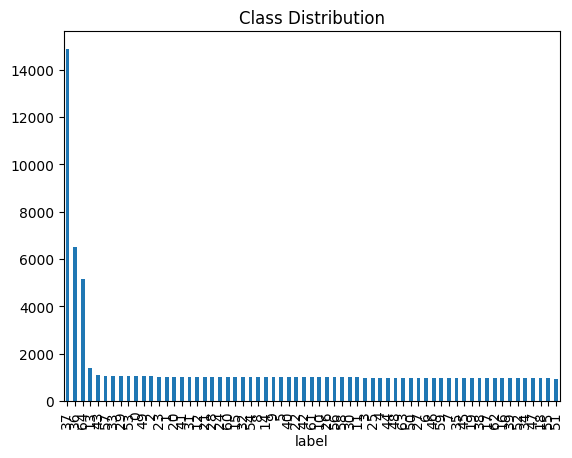

In [92]:
tempTrainDF["label"].value_counts().plot(kind="bar", title="Class Distribution");

In [93]:
tempValDF.describe()

,row_id,QuestionId,label,is_correct,Length
count,90.000000,90.000000,90.00000,90.000000,90.000000
mean,20585.022222,49933.766667,36.70000,0.533333,113.377778
std,10418.687163,27777.451586,18.21436,0.501683,24.815534
min,714.000000,31772.000000,0.00000,0.000000,72.000000
25%,13210.500000,31778.000000,24.50000,0.000000,96.000000
50%,22025.500000,33153.000000,37.00000,1.000000,109.500000
75%,29423.000000,86299.750000,52.00000,1.000000,128.750000
max,36404.000000,109465.000000,64.00000,1.000000,186.000000


In [94]:
# Convert to Hugging Face Dataset for training dataset
COLS = ['LLM_Content','label']

trainDataset = Dataset.from_pandas(tempTrainDF[COLS], split="train")
valDataset = Dataset.from_pandas(tempValDF[COLS], split="test")
testDataset = Dataset.from_pandas(testDF, split="test")
subDataset = Dataset.from_pandas(sample, split="test") # submit dataset

# trainDataset = Dataset.from_pandas(tempTrainDF, split="train")
# valDataset = Dataset.from_pandas(tempValDF, split="test")
# subDataset = Dataset.from_pandas(sample, split="test") # submit dataset

In [95]:
trainDataset

Dataset({
    features: ['LLM_Content', 'label', '__index_level_0__'],
    num_rows: 88965
})

In [96]:
testDataset

Dataset({
    features: ['row_id', 'QuestionId', 'QuestionText', 'MC_Answer', 'StudentExplanation', 'is_correct', 'LLM_Content'],
    num_rows: 3
})

In [97]:
subDataset

Dataset({
    features: ['row_id', 'Category:Misconception'],
    num_rows: 3
})

In [98]:
# for GPU only
!nvidia-smi  

Sun Sep 28 15:26:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             33W /   70W |    2037MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [99]:
del tempTrainDF 
del tempValDF

In [100]:
datasetDict = DatasetDict({
    "train" : trainDataset,
    "val"  : valDataset
    
})
datasetDict

DatasetDict({
    train: Dataset({
        features: ['LLM_Content', 'label', '__index_level_0__'],
        num_rows: 88965
    })
    val: Dataset({
        features: ['LLM_Content', 'label', '__index_level_0__'],
        num_rows: 90
    })
})

In [101]:
datasetDict["train"]

Dataset({
    features: ['LLM_Content', 'label', '__index_level_0__'],
    num_rows: 88965
})

In [102]:
def tokenizeFunc(batch):
    return tokenizer(batch["LLM_Content"],  max_length=CFG.maxLength, padding='max_length', truncation=True)

In [103]:
datasetDict = datasetDict.map(tokenizeFunc, batched=True)

Map:   0%|          | 0/88965 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

In [104]:
datasetDict

DatasetDict({
    train: Dataset({
        features: ['LLM_Content', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 88965
    })
    val: Dataset({
        features: ['LLM_Content', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 90
    })
})

In [105]:
datasetDict = datasetDict.rename_column("label", "labels")  # change name to labels 

In [106]:
datasetDict

DatasetDict({
    train: Dataset({
        features: ['LLM_Content', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 88965
    })
    val: Dataset({
        features: ['LLM_Content', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 90
    })
})

In [107]:
testDict = DatasetDict({
    "test": testDataset
    
})
testDict

DatasetDict({
    test: Dataset({
        features: ['row_id', 'QuestionId', 'QuestionText', 'MC_Answer', 'StudentExplanation', 'is_correct', 'LLM_Content'],
        num_rows: 3
    })
})

In [108]:
submitDict = DatasetDict({
    "test": subDataset
    # "test": subDataset
    
})
submitDict

DatasetDict({
    test: Dataset({
        features: ['row_id', 'Category:Misconception'],
        num_rows: 3
    })
})

In [109]:
# Evaluation Metrics
def compute_metric(eval_pred):
    logits , labels = eval_pred
    # predictions = np.argmax(logits, axis=-1)  # for mult-class
    top3_preds = np.argsort(logits, axis=-1)[:, -3:]
    match = (top3_preds == labels[:, None])
    predictions= top3_preds[:, 2]
    acc = (predictions == labels).mean()
    f1score  =  f1_score(labels, predictions, average='weighted', zero_division=1)
    recallScore = recall_score(labels, predictions,  average='weighted', zero_division=1)
    precision = precision_score(labels, predictions,  average='weighted', zero_division=1)
    
    # for map@3
    top3_preds = np.argsort(logits, axis=-1)[:, -3:]
    match = (top3_preds == labels[:, None])

    # Compute MAP@3 manually
    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    map3Score = map3 / len(labels)
    # map3List.append(map3Score)
    
    return {"accuracy": acc , "recall":  recallScore,  "precision":precision, 'f1-score': f1score ,
             "map_3":map3Score}
    
    
    
    

## LoRA fine tuing

In [110]:
lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        task_type="SEQ_CLS",  # for Sequence Classification
        # task_type="CAUSAL_LM", # for generative task
        bias="none",
        target_modules = ["q_proj", "o_proj", "k_proj", "v_proj",
                      "gate_proj", "up_proj", "down_proj"],
        lora_dropout= CFG.DROPOUT,
    )

In [111]:
model = get_peft_model(model, lora_config)

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [112]:
model.print_trainable_parameters()

trainable params: 33,196,544 || all params: 4,055,147,520 || trainable%: 0.8186


In [113]:
import trl
trl.__version__

'0.11.4'

In [114]:
N_SAMPLES = len(datasetDict["train"])  # Use train_df after the split
STEPS_PER_EPOCH = (N_SAMPLES // CFG.per_device_train_batch_size ) #* CFG.maxEpoch
VAL_STEPS_PER_EPOCH = len(datasetDict["val"]) // CFG.per_device_eval_batch_size
TOTAL_STEPS = int(STEPS_PER_EPOCH * CFG.maxEpoch)
NUM_WARMUP_STEPS = int(TOTAL_STEPS * 0.05)

print(f'BATCH_SIZE: {CFG.per_device_train_batch_size}, N_SAMPLES: {N_SAMPLES}, STEPS_PER_EPOCH: {STEPS_PER_EPOCH}')
print(f'NUM_WARMUP_STEPS: {NUM_WARMUP_STEPS}, TOTAL_STEPS: {TOTAL_STEPS}')
print(f"Val Step per epoch: {VAL_STEPS_PER_EPOCH}")

BATCH_SIZE: 5, N_SAMPLES: 88965, STEPS_PER_EPOCH: 17793
NUM_WARMUP_STEPS: 8, TOTAL_STEPS: 177
Val Step per epoch: 18


## STF Trainer Parameter

In [115]:
from trl import SFTTrainer, SFTConfig
torch_dtype = model.dtype
trainArg = SFTConfig(
    output_dir= "kaggle/working",
    # max_length= CFG.maxLength, # old version trl
    max_seq_length = CFG.maxLength, # new version trl
    per_device_train_batch_size =CFG.per_device_train_batch_size,
    per_device_eval_batch_size = CFG.per_device_eval_batch_size,
    gradient_accumulation_steps = CFG.gradient_accumulation_steps,
    eval_strategy= "steps",
    save_strategy= "steps",
    warmup_steps= NUM_WARMUP_STEPS, #CFG.warmup_steps,
    max_steps = TOTAL_STEPS,  #CFG.maxTrainStep, # set max train step size
    learning_rate=CFG.learning_rate,
    lr_scheduler_type="cosine", #"linear", #"cosine",
    save_total_limit=2,
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision ,  # INFER WITH FP16 BECAUSE KAGGLE IS T4 GPU
    bf16=True if torch_dtype == torch.bfloat16 else False,  # use bfloat16 precision, TRAIN WITH BF16 IF LOCAL GPU IS NEWER GPU  
    # fp16=True,
    logging_steps= CFG.evalSteps,
    eval_steps = CFG.evalSteps,
    optim="adamw_8bit",  #"paged_adamw_8bit",
    report_to = CFG.reportTo,
    do_eval=True,                # Perform evaluation at the end of training
    max_grad_norm=1.0,
    weight_decay=CFG.weight_decay,
    metric_for_best_model="map_3",
    greater_is_better=True,
    # memory optimial (reduce GPU memory but slowdown train speed )
    # gradient_checkpointing=True,
    # gradient_checkpointing_kwargs={'use_reentrant':False}, # for Mulitple -GPU
    load_best_model_at_end=True,
    # deepspeed=CFG.deepspeedConfigFile, # config error
    # label_names = targetClasses,

    
)

In [116]:
trainArg.bf16 

True

In [117]:
from transformers import DataCollatorWithPadding

In [118]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer= SFTTrainer(
    model=model,
    train_dataset=datasetDict["train"],
    eval_dataset = datasetDict["val"],
    args=trainArg,
    peft_config = lora_config,
    # formatting_func=formatFuct,
    data_collator = data_collator, 
    compute_metrics= compute_metric
    
    
)

/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:401: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [119]:
# Fix Batch size >1 , not define pad token id issues
eos_token_id=tokenizer.eos_token_id
model.config.use_cache=False
model.config.pad_token_id = tokenizer.pad_token_id

In [120]:
clearMemory() # clear memory before training

In [121]:
# %%time
# trainer.train()

In [122]:
def testValDataset(ds, maxNumData=10):
    for i, data in enumerate(ds):
        if (i >= maxNumData):
            break
        print(f"Data {i}")
        newPrompt = data["LLM_Content"]
        with torch.no_grad():
             inputIds = tokenizer(newPrompt, return_tensors="pt").to(device)
             logits = model(**inputIds).logits
             print(f"Logits Dimension: {logits.shape}")
             probabilities = nn.functional.softmax(logits, dim=-1) # get probilitity
             print(f"Probailities : {probabilities}")
             classID =logits.argmax().item()
             print(f"Class ID type {type(classID)}")
             classTxt = le.inverse_transform([classID])[0]
             actualClassID = data['labels']
             # print(f"Actual ClassID : {actualClassID}")
             actualClass = le.inverse_transform([actualClassID])[0]
             # Top3 prediction
             # acc = (probabilities == actualClassID).mean()
             # f1score  =  f1_score(actualClassID, probabilities, average='weighted', zero_division=1)
             # recallScore = recall_score(actualClassID, probabilities,  average='weighted', zero_division=1)
             # precision = precision_score(actualClassID, probabilities,  average='weighted', zero_division=1)
            
             # # for map@3
             top3_preds = np.argsort(logits.to(torch.float32).cpu(), axis=-1)[:, -3:]
             top3 = top3_preds.flatten() # convert to 1D 
             print(f"Top3 ID : {top3}")
             # classTxtArray = le.inverse_transform(top3) # convert class ID to Label 
             match = (top3_preds == actualClassID)
                    
             # Compute MAP@3 manually
             map3 = 0
             for i in range(len([actualClassID])):
                if match[i, 0]:
                    map3 += 1.0
                elif match[i, 1]:
                    map3 += 1.0 / 2
                elif match[i, 2]:
                    map3 += 1.0 / 3
             map3Score = map3 / len([actualClassID])
        

        print(f"""Query: {newPrompt}
              Predict Class ID: {classID}
              Predict Text: {classTxt}
              Actual Class ID: {actualClassID}
              Actual Class Text: {actualClass}
             MAP@3 Score : {map3Score}""")
        print("-"*30)

In [123]:
testValDataset(datasetDict["val"], 10)

Data 0
Logits Dimension: torch.Size([1, 65])
Probailities : tensor([[9.4771e-06, 3.6955e-05, 3.5858e-04, 1.9455e-04, 2.2125e-03, 1.4591e-04,
         8.1539e-05, 1.7643e-04, 1.0633e-04, 1.0742e-02, 2.6512e-04, 9.1934e-04,
         4.0245e-04, 2.2125e-03, 2.2507e-04, 1.0300e-03, 1.9550e-05, 1.2054e-03,
         4.3678e-04, 8.2493e-05, 2.7618e-03, 3.5858e-04, 2.6894e-04, 5.4240e-06,
         5.4836e-06, 3.1281e-03, 7.0496e-03, 8.3074e-07, 7.9590e-02, 2.7657e-04,
         2.9907e-03, 1.5488e-03, 5.1498e-04, 1.1902e-03, 9.1076e-05, 1.2112e-04,
         3.2043e-04, 4.2725e-03, 1.4114e-04, 1.4496e-04, 1.3173e-05, 8.7619e-06,
         2.0564e-06, 8.6212e-04, 3.3264e-03, 3.5095e-04, 8.2812e-01, 1.1063e-03,
         3.1888e-06, 2.1667e-03, 1.8883e-04, 9.3579e-06, 8.6975e-04, 2.0146e-05,
         6.5994e-04, 9.9182e-05, 1.3411e-05, 8.4839e-03, 1.8597e-05, 6.1989e-05,
         6.7139e-04, 8.4305e-04, 7.5150e-04, 2.5024e-02, 1.3657e-03]],
       device='cuda:0', dtype=torch.bfloat16)
Class ID type

In [124]:
submitDict

DatasetDict({
    test: Dataset({
        features: ['row_id', 'Category:Misconception'],
        num_rows: 3
    })
})

# Final Prediction

In [125]:
def predictTestDataset(ds):
    result = []
    idx = []
    for i, data in enumerate(ds):
        print(f"Data {i}")
        rowId= data["row_id"]
        newPrompt = data["LLM_Content"]
        with torch.no_grad():
             inputIds = tokenizer(newPrompt, return_tensors="pt").to(device)
             logits = model(**inputIds).logits
             probabilities = nn.functional.softmax(logits, dim=-1) # get probilitity
             top3_preds = np.argsort(logits.to(torch.float32).cpu(), axis=-1)[:, -3:]
             top3 = top3_preds.flatten() # convert to 1D 
             classTxtArray = le.inverse_transform(top3) # convert class ID to Label 
             top3_labels    = classTxtArray.reshape(top3.shape)
             temp = ""
             # for preds in top3_labels:
             temp += temp + " ".join(top3_labels)
             # result.append(temp)
             # print((top3.shape))
             result.append(temp[:-1])
             idx.append(rowId)

        print(f"RowID: {rowId}\n\rQuery: {newPrompt}\n\rPredict Top3 Class ID : {top3}\n\rClass Text : {temp}")
        print("-"*30)
    return idx, result


In [126]:
rowID ,predictResult = predictTestDataset(testDict["test"])
final =  pd.DataFrame({"row_id": rowID, "Category:Misconception": predictResult})
final

Data 0
RowID: 36696
Query: You are an expert in analyzing students' answers to math problems and identifying specific types of misunderstandings.
Given the following information, classify the student's misunderstanding.

Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Answer: \( \frac{1}{3} \)
Correct: True
Student Explanation: I think that 1/3 is the answer, as it's the simplest form of 3/9.

Please provide the type of misunderstanding the student has.

Predict Top3 Class ID : tensor([63, 28, 46])
Class Text : True_Misconception:Wrong_term False_Misconception:Tacking True_Misconception:FlipChange
------------------------------
Data 1
RowID: 36697
Query: You are an expert in analyzing students' answers to math problems and identifying specific types of misunderstandings.
Given the following information, classify the student's misunderstanding.

Question: What fract

,row_id,Category:Misconception
0,36696,True_Misconception:Wrong_term False_Misconcept...
1,36697,True_Misconception:Wrong_term False_Misconcept...
2,36698,True_Misconception:Wrong_term False_Misconcept...


In [127]:
predictResult


['True_Misconception:Wrong_term False_Misconception:Tacking True_Misconception:FlipChang',
 'True_Misconception:Wrong_term False_Misconception:Tacking True_Misconception:FlipChang',
 'True_Misconception:Wrong_term False_Misconception:Tacking True_Misconception:FlipChang']

In [128]:
final.to_csv('submission.csv', index = False)

In [129]:
pd.read_csv('submission.csv')

,row_id,Category:Misconception
0,36696,True_Misconception:Wrong_term False_Misconcept...
1,36697,True_Misconception:Wrong_term False_Misconcept...
2,36698,True_Misconception:Wrong_term False_Misconcept...
